#<center> Hybrid GAN </center>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
# creating minibatches
def mini_batch(X, size):
    # generate random integers of shape size*1 and in range 0 to len(X)
    # treat x_bat as indices and return values from X at those indices
    x_bat = X[np.random.randint(len(X), size = (size,1))]
    x_bat = x_bat.reshape(size, X.shape[1], X.shape[2], X.shape[3])
    
    return x_bat

In [0]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

170500096/170498071 [==============================] - 103s 1us/step


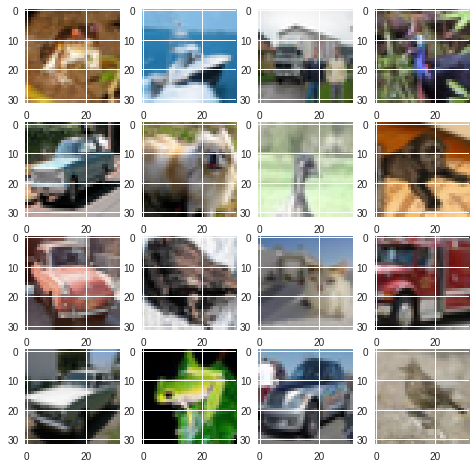

In [4]:
# importing dataset
image_data = tf.keras.datasets.cifar10
(x_train, _), (x_test, _) = image_data.load_data()


# shuffling
np.random.shuffle(normalize(x_train))
np.random.shuffle(normalize(x_test))


# plotting a random sample from x_train
fig = plt.figure(figsize=(8,8))


col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    plt.imshow(x_train[j])
    j+=8
plt.show()

In [0]:
tf.reset_default_graph()

D_in = tf.placeholder(tf.float32, [None, 32,32,3], name="D_in")
G_in = tf.placeholder(tf.float32, [None, 32,32,3], name="G_in")
D_label = tf.placeholder(tf.float32, [None, 1])
G_label = tf.placeholder(tf.float32, [None, 1])

with tf.device("/gpu:0"):
    def Generator(z):
        
        global print_flag_gen
        
        # generator model architecture
        gl1  = tf.layers.conv2d(z, 64, kernel_size=(2,2), strides=(1,1), padding="same", 
                                             kernel_initializer=tf.initializers.random_normal)
        gmx1 = tf.layers.max_pooling2d(gl1, pool_size=(2,2), strides=(2,2), padding="SAME")
        gbn1 = tf.layers.batch_normalization(gmx1)
        ga1  = tf.nn.relu(gbn1)
        
        
        gl2 = tf.layers.conv2d(ga1, 128, kernel_size=(2,2), strides=(1,1), padding="same", 
                                             kernel_initializer=tf.initializers.random_normal)
        gmx2 = tf.layers.max_pooling2d(gl2, pool_size=(2,2), strides=(2,2), padding="SAME")
        gbn2 = tf.layers.batch_normalization(gmx2)
        ga2  = tf.nn.relu(gbn2)
        
        
        gl3 = tf.layers.conv2d(ga2, 256, kernel_size=(2,2), strides=(1,1), padding="same", 
                                             kernel_initializer=tf.initializers.random_normal)
        gmx3 = tf.layers.max_pooling2d(gl3, pool_size=(2,2), strides=(2,2), padding="SAME")
        gbn3 = tf.layers.batch_normalization(gmx3)
        ga3  = tf.nn.relu(gbn3)
        
        
        gl9 = tf.layers.conv2d(ga3, 512, kernel_size=(2,2), strides=(1,1), padding="same", 
                                             kernel_initializer=tf.initializers.random_normal)
        gmx9 = tf.layers.max_pooling2d(gl9, pool_size=(2,2), strides=(2,2), padding="SAME")
        gbn9 = tf.layers.batch_normalization(gmx9)
        ga9  = tf.nn.relu(gbn9)
        
        
        gl4  = tf.layers.conv2d_transpose(ga9, 512, kernel_size=(5,5), strides=(2,2), padding="same",
                                             kernel_initializer=tf.initializers.random_normal)        
        gbn4 = tf.layers.batch_normalization(gl4)
        ga4  = tf.nn.relu(gbn4)
        
        
        gl5  = tf.layers.conv2d_transpose(ga4, 256, kernel_size=(4,4), strides=(2,2), padding="same",
                                             kernel_initializer=tf.initializers.random_normal)
        gbn5 = tf.layers.batch_normalization(gl5)
        ga5  = tf.nn.relu(gbn5)
        
        
        gl6  = tf.layers.conv2d_transpose(ga5, 128, kernel_size=(4,4), strides=(2,2), padding="same",
                                             kernel_initializer=tf.initializers.random_normal)
        gbn6 = tf.layers.batch_normalization(gl6)
        ga6  = tf.nn.relu(gbn6)
        
        
        gl7  = tf.layers.conv2d_transpose(ga6, 64, kernel_size=(4,4), strides=(2,2), padding="same",
                                             kernel_initializer=tf.initializers.random_normal)
        gbn7 = tf.layers.batch_normalization(gl7)
        ga7  = tf.nn.relu(gbn7)
        
   
        gl8  = tf.layers.conv2d_transpose(ga7, 3, kernel_size=(4,4), strides=(1,1), padding="same",
                                             kernel_initializer=tf.initializers.random_normal)
        
    
        if print_flag_gen == True:
            print("Input            : ",z.shape)
            print("Layer1           : ",ga1.shape)
            print("Layer2           : ",ga2.shape)
            print("Layer3           : ",ga3.shape)
            print("Layer4           : ",ga9.shape)
            print("Layer5           : ",ga4.shape) 
            print("Layer6           : ",ga5.shape)
            print("Layer7           : ",ga6.shape)
            print("Layer8           : ",ga7.shape) 
            print("Layer9           : ",gl8.shape)
            print_flag_gen = False
        
        return gl8

In [0]:
with tf.device("/gpu:0"):
    def Discriminator(D_input, train_flag):
        global print_flag_dis
        
        # discriminator model architecture
        
        dl1  = tf.layers.conv2d(D_input, filters=64, kernel_size=(2,2), strides=(2,2), padding="SAME", trainable=train_flag)
        dbn1 = tf.layers.batch_normalization(dl1, trainable=train_flag)
        da1  = tf.nn.leaky_relu(dbn1, 0.2)
        
        
        dl2  = tf.layers.conv2d(da1, filters=128, kernel_size=(2,2), strides=(2,2), padding="SAME", trainable=train_flag)
        dbn2 = tf.layers.batch_normalization(dl2, trainable=train_flag)
        da2  = tf.nn.leaky_relu(dbn2, 0.2)
        
        
        dl3  = tf.layers.conv2d(da2, filters=256, kernel_size=(2,2), strides=(2,2), padding="SAME", trainable=train_flag)
        dbn3 = tf.layers.batch_normalization(dl3, trainable=train_flag)
        da3  = tf.nn.leaky_relu(dbn3, 0.2)
        
        
        dl4  = tf.layers.conv2d(da3, filters=512, kernel_size=(2,2), strides=(2,2), padding="SAME", trainable=train_flag)
        dbn4 = tf.layers.batch_normalization(dl4, trainable=train_flag)
        da4  = tf.nn.leaky_relu(dbn4, 0.2)
        
        flat = tf.layers.flatten(da4)
        
        dense = tf.nn.leaky_relu(tf.layers.dense(flat, 1))
        
        if print_flag_dis == True:
            print("input            : ", D_input.shape)
            print("layer1           : ", da1.shape)
            print("layer2           : ", da2.shape)
            print("layer3           : ", da3.shape)
            print("layer4           : ", da4.shape)
            print("layer5           : ", dense.shape)
            
            print_flag_dis = False
            
        return dense

In [7]:
print_flag_dis = True
print_flag_gen = True
# to avoid initialization errors generator and discriminator functions are called before tf.global_variables_initializer()
# G_z stands for G(z)
# D_G_z_T stands for D(G(z)) with F means train_flag is False and T means train_flag is True
print("Generator: ")
G_z = Generator(G_in)
print("\n\nDiscriminator: ")
D_fake = Discriminator(G_z, train_flag=False)
D_real = Discriminator(D_in, train_flag=True)

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))


g_ops = tf.train.AdamOptimizer(0.0004, beta1=0.5).minimize(g_loss)
d_ops = tf.train.AdamOptimizer(0.0004, beta1=0.5).minimize(d_loss)

Generator: 
Input            :  (?, 32, 32, 3)
Layer1           :  (?, 16, 16, 64)
Layer2           :  (?, 8, 8, 128)
Layer3           :  (?, 4, 4, 256)
Layer4           :  (?, 2, 2, 512)
Layer5           :  (?, 4, 4, 512)
Layer6           :  (?, 8, 8, 256)
Layer7           :  (?, 16, 16, 128)
Layer8           :  (?, 32, 32, 64)
Layer9           :  (?, 32, 32, 3)


Discriminator: 
input            :  (?, 32, 32, 3)
layer1           :  (?, 16, 16, 64)
layer2           :  (?, 8, 8, 128)
layer3           :  (?, 4, 4, 256)
layer4           :  (?, 2, 2, 512)
layer5           :  (?, 1)


In [9]:
decorate = 0

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(tf.global_variables_initializer())

# hyperparameters
sample_size = 32
epochs = 501
noise_sample_len = tf.shape(G_in)[1]

g_l = []
g_l_se = []
d_l = []


# here goes the training
for i in range(epochs):
    
    # train the discriminator
    for j in range(10):
        # create noise sample
        noise = np.random.normal(0, 0.1,[sample_size, 32,32,3])
        # create sample of real images
        real_imgs = normalize(mini_batch(x_train, sample_size))
        
        # train the discriminator
        sess.run(d_ops, {D_in: real_imgs, G_in: noise})
        d_l.append(sess.run(d_loss, {D_in: real_imgs, G_in: noise}))
    
    # train the generator
    
    for k in range(1):
        sess.run(g_ops, {G_in: noise})
        g_l.append(sess.run(g_loss, {G_in: noise}))
        
    if i % 100 == 0:
        clear_output()
        print("Iterations complete: ", i)
        print("="*decorate)
        decorate+=1
        

Iterations complete:  500
=====


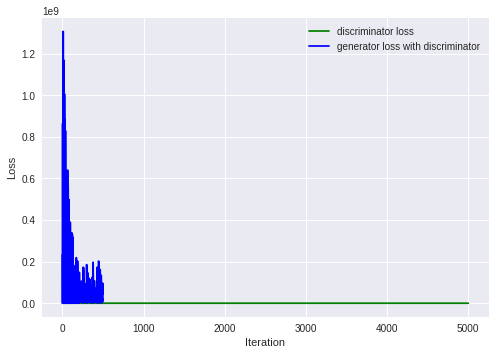

In [10]:
# plotting loss
plt.plot(range(0,len(d_l)), d_l, 'g', label='discriminator loss')
plt.plot(range(0,len(g_l)), g_l, 'b', label='generator loss with discriminator')
plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

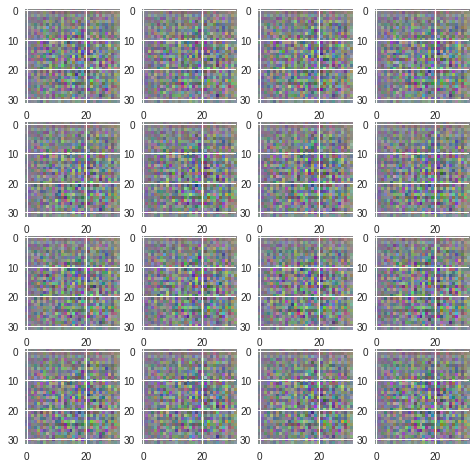

In [11]:
pred = sess.run(G_z, {G_in: np.random.normal(0, 0.1,[sample_size, 32,32,3])})
pred = normalize(pred)


fig2 = plt.figure(figsize=(8,8))

col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig2.add_subplot(row, col, i)
    plt.imshow(pred[j])
    j+=1
plt.show()

##Resources     

* https://arxiv.org/abs/1406.2661
* https://arxiv.org/abs/1511.06434
* https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py
* https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
* https://github.com/soumith/ganhacks
* https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN
* https://julianzaidi.wordpress.com/2017/04/24/deep-convolution-gan-dcgan-architecture-and-training/
* https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/
